# 含并行连结的网络（GoogLeNet）
:label:`sec_googlenet`

在2014年的ImageNet图像识别挑战赛中，一个名叫*GoogLeNet* :cite:`Szegedy.Liu.Jia.ea.2015` 的网络结构大放异彩。
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。
毕竟，以前流行的网络使用小到 $1 \times 1$ ，大到 $11 \times 11$ 的卷积核。
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。
在本节中，我们将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，但是现在有了更好的训练算法，这些特性不是必要的。


## (**Inception块**)

在GoogLeNet中，基本的卷积块被称为*Inception块*（Inception block）。这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

![Inception块的结构。](../img/inception.svg)
:label:`fig_inception`

如 :numref:`fig_inception` 所示，Inception块由四条并行路径组成。
前三条路径使用窗口大小为 $1\times 1$、$3\times 3$ 和 $5\times 5$ 的卷积层，从不同空间大小中提取信息。
中间的两条路径在输入上执行 $1\times 1$ 卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用 $3\times 3$ 最大池化层，然后使用 $1\times 1$ 卷积层来改变通道数。
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道的数量。


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

class Inception(nn.Block):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1 x 1卷积层
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # 线路2，1 x 1卷积层后接3 x 3卷积层
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,
                              activation='relu')
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,
                              activation='relu')
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # 在通道维度上连结输出
        return np.concatenate((p1, p2, p3, p4), axis=1)

那么为什么GoogLeNet这个网络如此有效呢？
首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
同时，我们可以为不同的滤波器分配不同数量的参数。


## [**GoogLeNet模型**]

如 :numref:`fig_inception_full` 所示，GoogLeNet 一共使用 9 个Inception块和全局平均池化层的堆叠来生成其估计值。Inception块之间的最大池化层可降低维度。
第一个模块类似于 AlexNet 和 LeNet，Inception块的栈从VGG继承，全局平均池化层避免了在最后使用全连接层。

![GoogLeNet结构。](../img/inception-full.svg)
:label:`fig_inception_full`

现在，我们逐一实现GoogLeNet的每个模块。第一个模块使用 64 个通道、 $7\times 7$ 卷积层。


In [2]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第二个模块使用两个卷积层：第一个卷积层是 64个通道、 $1\times 1$ 卷积层；第二个卷积层使用将通道数量增加三倍的 $3\times 3$ 卷积层。
这对应于 Inception 块中的第二条路径。


In [3]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第三个模块串联两个完整的Inception块。
第一个 Inception 块的输出通道数为 $64+128+32+32=256$，四个路径之间的输出通道数量比为 $64:128:32:32=2:4:1:1$。
第二个和第三个路径首先将输入通道的数量分别减少到 $96/192=1/2$ 和 $16/192=1/12$，然后连接第二个卷积层。第二个 Inception 块的输出通道数增加到 $128+192+96+64=480$，四个路径之间的输出通道数量比为 $128:192:96:64 = 4:6:3:2$。
第二条和第三条路径首先将输入通道的数量分别减少到 $128/256=1/2$ 和 $32/256=1/8$。


In [4]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第四模块更加复杂，
它串联了5个Inception块，其输出通道数分别是 $192+208+48+64=512$ 、 $160+224+64+64=512$ 、 $128+256+64+64=512$ 、 $112+288+64+64=528$ 和 $256+320+128+128=832$ 。
这些路径的通道数分配和第三模块中的类似，首先是含 $3×3$ 卷积层的第二条路径输出最多通道，其次是仅含 $1×1$ 卷积层的第一条路径，之后是含 $5×5$ 卷积层的第三条路径和含 $3×3$ 最大池化层的第四条路径。
其中第二、第三条路径都会先按比例减小通道数。
这些比例在各个 Inception 块中都略有不同。


In [5]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

第五模块包含输出通道数为 $256+320+128+128=832$ 和 $384+384+128+128=1024$ 的两个Inception块。
其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。
需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均池化层，将每个通道的高和宽变成1。
最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。


In [6]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128), nn.GlobalAvgPool2D())

net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

GoogLeNet 模型的计算复杂，而且不如 VGG 那样便于修改通道数。
[**为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96**]，这简化了计算。下面演示各个模块输出的形状变化。


In [7]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


## [**训练模型**]

和以前一样，我们使用 Fashion-MNIST 数据集来训练我们的模型。在训练之前，我们将图片转换为 $96 \times 96$ 分辨率。


loss 0.254, train acc 0.903, test acc 0.901
2214.6 examples/sec on gpu(0)


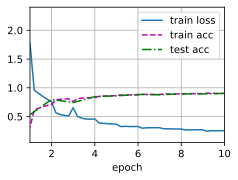

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* Inception 块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并使用 $1×1$ 卷积层减少每像素级别上的通道维数从而降低模型复杂度。
*  GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在 ImageNet 数据集上通过大量的实验得来的。
* GoogLeNet 和它的后继者们一度是 ImageNet 上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。


## 练习

1. GoogLeNet 有数个后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
    * 添加批量归一化层 :cite:`Ioffe.Szegedy.2015`（batch normalization），在 :numref:`sec_batch_norm`中将介绍）。
    * 对 Inception 模块进行调整。
    * 使用标签平滑（label smoothing）进行模型正则化 :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`。
    * 加入残差连接 :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017` ，（ :numref:`sec_resnet` 将介绍）。
1. 使用 GoogLeNet 的最小图像大小是多少？
1. 将 AlexNet、VGG 和 NiN 的模型参数大小与 GoogLeNet 进行比较。后两个网络结构是如何显著减少模型参数大小的？


[Discussions](https://discuss.d2l.ai/t/1873)
